# Continuous Authentication
Continuous Authentication is an interesting area of computer security that has the potential to be an addition to passwords, but act as a form of continuous password, using biometrics


In [1]:
import time
import config
import pathlib
import preprocess

subject = 14

# First, let's make sure we process all our subjects' data
if not pathlib.Path(config.FEATURE_FILE).exists():
    preprocess.multiprocess_all_subjects()
    print("Copying individual user feature files to master data file...", end=" ")
    start = time.time()
    preprocess.create_feature_file()
    print(f"took {time.time() - start:.3f}s")

# Preprocessing the data is easy, we can pass in a specific subject to get the data for.
# This data is shuffled automatically, however if you don't want it shuffled, you can 
# pass shuffled=False to the binary classify function
X_train, X_test, y_train, y_test = preprocess.binary_classify(subject=subject, save=False)

# When looking at the head, we will notice two values, 0 and 1 (if the data is shuffled, 
# otherwise, you'll just see 1's). The 0 represents imposer user data, while 1 represents 
# a genuine user row.
y_train.head()

# Let's also print the configuration values
print(f"{config.FEATURE_FILE = } {config.RANDOM_STATE = } {config.SEQUENCE_LENGTH = }")

config.FEATURE_FILE = 'data/proc/features_SQ384.csv' config.RANDOM_STATE = 4 config.SEQUENCE_LENGTH = 384


# Running models
There are two main types of models I'm working with here, *classifiers* and *regressors*. Classifiers are here to do binary classification, is the mouse event presented to the model a genuine user action or an imposter user action. Regressors, on the other hand, assign somewhat a probability to the event.


In [2]:
from sklearn.neighbors import KNeighborsClassifier

# We can create the classifier
classifier = KNeighborsClassifier()
# Fit our training data to the classifier
classifier.fit(X_train, y_train)
# And create predictions from that classifier
y_cls_pred = classifier.predict(X_test)

In [3]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)
y_reg_pred = regressor.predict(X_test)

# Validating the models
Here are two blocks for validating the classifier and regressor, respectively. We can use some traditional metrics to evaluate the classifier,
and figure a Trust Score for the regressor. The idea of a Trust Score is to lock out the user once the score breaches a certain threshold, in 
our case that threshold is 70.

Accuracy: 99.305%
Precision: 99.233%
Recall: 99.354%
F1: 99.294%


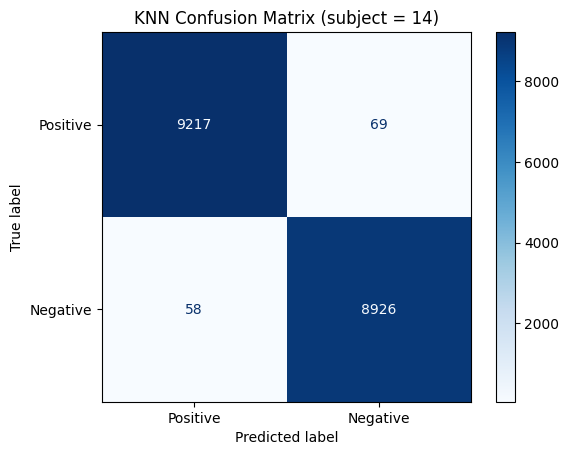

In [4]:
import validation
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

validation.calculate_metric_scores(y_test, y_cls_pred)

disp = ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_test,
    y_test,
    display_labels=["Positive", "Negative"],
    cmap=plt.cm.Blues,
).ax_.set_title(f"KNN Confusion Matrix ({subject = })")

plt.show()

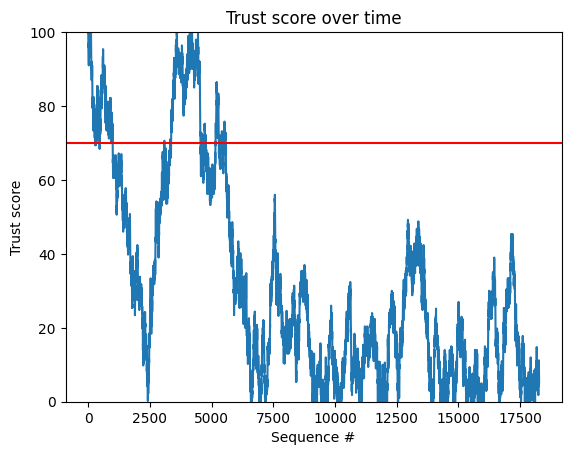

In [6]:
# We will store every C value in order to plot it in matplotlib
C = [config.STARTING_VALUE]

for pred in y_reg_pred:
    last_value = C[-1]

    if pred >= 0.5:
        C.append(min(last_value + pred, 100))
    elif pred >= 0.3:
        C.append(max(last_value - (1 - pred), 0))
    else:
        C.append(max(last_value - 1, 0))

window = (0, len(y_reg_pred))
# window = (0, 2000)
plt.plot(range(len(y_reg_pred) + 1)[window[0]:window[1]], C[window[0]:window[1]])

plt.title("Trust score over time")
plt.xlabel('Sequence #')
plt.ylabel('Trust score')

# Let's place a line at the treshold to show when the user would be
# locked out
plt.axhline(y=config.THRESHOLD, color="r", linestyle="-", label="Threshold")

# Trust score can vary between 0-100
plt.ylim(0, 100)

plt.show()